In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
conn = sqlite3.connect("idoe_corp_data.db")
curs = conn.cursor()
index_commands = [
    'CREATE INDEX IF NOT EXISTS idx_cees_corpid ON corp_enrollment_ell_sped_2024("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ctgr_corpid ON corp_third_grade_reading("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cee_corpid ON corp_enrollment_ethnicity_2024("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ca_corpid ON corp_act("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_car_corpid ON corp_attendance_rates("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cca_corpid ON corp_absenteeism("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ela_corpid ON corp_ilearn_ela("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_math_corpid ON corp_ilearn_math("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cf_corpid ON corp_finances("Corporation ID");',
]

# Execute each index creation
for cmd in index_commands:
    curs.execute(cmd)


In [4]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables["name"]:
    print(table)
    columns = pd.read_sql_query("PRAGMA table_info("+table+");", conn)
    print(columns["name"])

corp_enrollment_grade_gender
0              Corporation ID
1                   Corp Name
2                Pre-K Female
3                  Pre-K Male
4         Kindergarten Female
5           Kindergarten Male
6              Grade 1 Female
7                Grade 1 Male
8              Grade 2 Female
9                Grade 2 Male
10             Grade 3 Female
11               Grade 3 Male
12             Grade 4 Female
13               Grade 4 Male
14             Grade 5 Female
15               Grade 5 Male
16             Grade 6 Female
17               Grade 6 Male
18             Grade 7 Female
19               Grade 7 Male
20             Grade 8 Female
21               Grade 8 Male
22             Grade 9 Female
23               Grade 9 Male
24            Grade 10 Female
25              Grade 10 Male
26            Grade 11 Female
27              Grade 11 Male
28            Grade 12 Female
29              Grade 12 Male
30     Grade 12+/Adult Female
31       Grade 12+/Adult Male
32    TOTAL

In [5]:
f = pd.read_sql_query("SELECT * FROM corp_finances limit 10;", conn)
f.head()

,Year,Corporation ID,Corporation Name,IDOE School ID,School Name,Enrollment,School Per/Student,Corp Per/Student,State Per/Student,Corp Percent Change,State Percent Change,Instructional per/student,OtherInstructional per/student,InstructionalShared per/student,Operational per/student,OperationalShared per/student,FedFund per/student,StateLocalFund per/student,ExcludedOtherExpend per/student,ExcludedFoodExpend per/student
0,2022,0015,Adams Central Community Schools,0013,Adams Central Middle School,313.0,9501.99,9659.39,9917.29,-1.629502,-4.187636,5448.30,0.0,1825.57,0.00,2228.12,1546.24,7955.75,4206.17,400.31
1,2022,0015,Adams Central Community Schools,0020,Adams Central Elementary School,645.0,9158.21,9659.39,9917.29,-5.188526,-7.654107,5104.52,0.0,1825.57,0.00,2228.12,1784.43,7373.79,4206.17,400.31
2,2022,0015,Adams Central Community Schools,0021,Adams Central High School,368.0,10671.67,9659.39,9917.29,10.479751,7.606715,6617.98,0.0,1825.57,0.00,2228.12,1556.39,9115.28,4206.17,400.31
3,2022,0025,North Adams Community Schools,0029,Bellmont Senior High School,641.0,13427.05,12311.39,9917.29,9.062015,35.390313,7175.41,0.0,2690.85,826.17,2734.62,2596.91,10830.14,4334.23,678.99
4,2022,0025,North Adams Community Schools,0033,Bellmont Middle School,326.0,12788.56,12311.39,9917.29,3.875842,28.952163,6669.09,0.0,2690.85,694.00,2734.62,2603.41,10185.14,3884.51,678.99


In [4]:
query = """
SELECT 
    cees."Corporation ID", 
    cees."Corp Name",
    AVG(ctgr."Non-GCE, Promoted to 4th Grade" * 1.0 / ctgr."Number of Test Takers") AS "Non-GCE Promote %",
    cees."ELL %",
    cees."Special Education %",
    
    CAST(cee."Free/Reduced Price Meals" AS REAL) / cees."Total Enrollment" AS "FRPM_%",
    CAST(cee."American Indian" AS REAL) / cees."Total Enrollment" AS "Pct American Indian",
    CAST(cee."Asian" AS REAL) / cees."Total Enrollment" AS "Pct Asian",
    CAST(cee."Black" AS REAL) / cees."Total Enrollment" AS "Pct Black",
    CAST(cee."Hispanic" AS REAL) / cees."Total Enrollment" AS "Pct Hispanic",
    CAST(cee."Multiracial" AS REAL) / cees."Total Enrollment" AS "Pct Multiracial",
    CAST(cee."Native Hawaiian or Other Pacific Islander" AS REAL) / cees."Total Enrollment" AS "Pct Pacific Islander",
    CAST(cee."White" AS REAL) / cees."Total Enrollment" AS "Pct White",

    AVG(cca."Chronically Absent Percent") AS "Chronically Absent Percent",
    AVG(car."2023-2024 ATTENDANCE RATE") AS "AVG_ATT_RATE",
    cees."Total Enrollment",
    CAST(ela."ELA Total Tested" AS REAL) / cees."Total Enrollment" AS "% Tested ELA",
    CAST(math."Math Total Tested" AS REAL) / cees."Total Enrollment" AS "% Tested Math",
    AVG(cf."Corp Per/Student") AS "Corp Per/Student",
    ela."ELA Proficient %",
    math."Math Proficient %"
FROM corp_enrollment_ell_sped_2024 cees
INNER JOIN corp_third_grade_reading ctgr 
    ON cees."Corporation ID" = ctgr."Corporation ID"
INNER JOIN corp_enrollment_ethnicity_2024 cee 
    ON cees."Corporation ID" = cee."Corporation ID"
INNER JOIN corp_act ca 
    ON cees."Corporation ID" = ca."Corporation ID"
INNER JOIN corp_attendance_rates car 
    ON ca."Corporation ID" = car."Corporation ID"
INNER JOIN corp_absenteeism cca 
    ON car."Corporation ID" = cca."Corporation ID"
INNER JOIN corp_ilearn_ela ela 
    ON cca."Corporation ID" = ela."Corporation ID"
INNER JOIN corp_ilearn_math math 
    ON ela."Corporation ID" = math."Corporation ID"
INNER JOIN corp_finances cf 
    ON cees."Corporation ID" = cf."Corporation ID"
GROUP BY 
    cees."Corporation ID", 
    cees."Corp Name",  
    cees."ELL %", 
    cees."Special Education %", 
    cees."Total Enrollment", 
    cee."Free/Reduced Price Meals",
    cee."American Indian",
    cee."Asian",
    cee."Black",
    cee."Hispanic",
    cee."Multiracial",
    cee."Native Hawaiian or Other Pacific Islander",
    cee."White",
    ela."ELA Total Tested",
    math."Math Total Tested",
    ela."ELA Proficient %",
    math."Math Proficient %"
"""

df = pd.read_sql_query(query, conn)
df.head()

,Corporation ID,Corp Name,Non-GCE Promote %,ELL %,Special Education %,FRPM_%,Pct American Indian,Pct Asian,Pct Black,Pct Hispanic,...,Pct Pacific Islander,Pct White,Chronically Absent Percent,AVG_ATT_RATE,Total Enrollment,% Tested ELA,% Tested Math,Corp Per/Student,ELA Proficient %,Math Proficient %
0,15,Adams Central Community Schools,0.017691,0.023529,0.152941,0.271324,0.000735,0.005147,0.005882,0.046324,...,0.000000,0.919118,0.038941,0.966399,1360,0.437500,0.437500,9659.39,0.484034,0.611765
1,25,North Adams Community Schools,0.042012,0.007600,0.179861,0.454718,0.002533,0.005066,0.026599,0.118429,...,0.001267,0.795440,0.092294,0.973404,1579,0.346422,0.345155,12311.39,0.385740,0.339450
2,35,South Adams Schools,0.004467,0.100153,0.188838,0.455657,0.001529,0.008410,0.006881,0.116208,...,0.000765,0.848624,0.074315,0.957031,1308,0.429664,0.429664,12086.48,0.400356,0.521352
3,125,MSD Southwest Allen County Schls,0.024144,0.020649,0.119391,0.236400,0.002250,0.046195,0.082859,0.072005,...,0.000662,0.737790,0.031000,0.994553,7555,0.460622,0.460490,8967.90,0.529885,0.528888
4,225,Northwest Allen County Schools,0.012208,0.036025,0.157700,0.237743,0.001193,0.062865,0.035787,0.060360,...,0.000596,0.778600,0.044749,0.961639,8383,0.465347,0.464989,8800.10,0.489105,0.463828


In [14]:
df.to_csv('df.csv', index=False)

In [15]:
df.describe()

,Corporation ID,Non-GCE Promote %,ELL %,Special Education %,FRPM_%,Pct American Indian,Pct Asian,Pct Black,Pct Hispanic,Pct Multiracial,Pct Pacific Islander,Pct White,Chronically Absent Percent,AVG_ATT_RATE,Total Enrollment,% Tested ELA,% Tested Math,Corp Per/Student,ELA Proficient %,Math Proficient %
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,4946.323529,0.031612,0.048882,0.179392,0.489895,0.001608,0.012668,0.070919,0.103450,0.041195,0.000690,0.769444,0.123441,0.941002,3235.679739,0.440615,0.440499,10500.025458,0.386926,0.393420
std,2556.053047,0.029637,0.075441,0.072642,0.160130,0.001592,0.030886,0.152667,0.119139,0.029288,0.001273,0.234431,0.056480,0.018166,3980.025284,0.049238,0.049227,1749.774027,0.120242,0.141787
min,15.000000,0.000000,0.000000,0.001684,0.000000,0.000000,0.000000,0.000000,0.005076,0.001847,0.000000,0.001178,0.029026,0.857031,76.000000,0.201117,0.201117,0.000000,0.027778,0.000000
25%,2986.250000,0.012801,0.006311,0.151065,0.396127,0.000555,0.002155,0.004793,0.033580,0.022766,0.000000,0.697106,0.087361,0.934012,1046.000000,0.422955,0.423011,9625.185000,0.313199,0.317137
50%,4932.500000,0.022583,0.018785,0.171507,0.501525,0.001335,0.004564,0.009923,0.057041,0.031830,0.000380,0.877888,0.111322,0.943322,1647.000000,0.437342,0.437342,10223.140000,0.389131,0.390853
75%,6857.500000,0.039837,0.055241,0.198250,0.578386,0.002190,0.009078,0.055103,0.118551,0.051110,0.000935,0.926622,0.146999,0.951130,3589.250000,0.455752,0.455711,11245.695000,0.466895,0.488703
max,9950.000000,0.194760,0.420561,0.804469,1.000000,0.014103,0.282162,0.931575,0.771930,0.210526,0.015249,0.974836,0.378023,0.997463,28506.000000,0.986154,0.986154,20630.080001,0.696309,0.734927


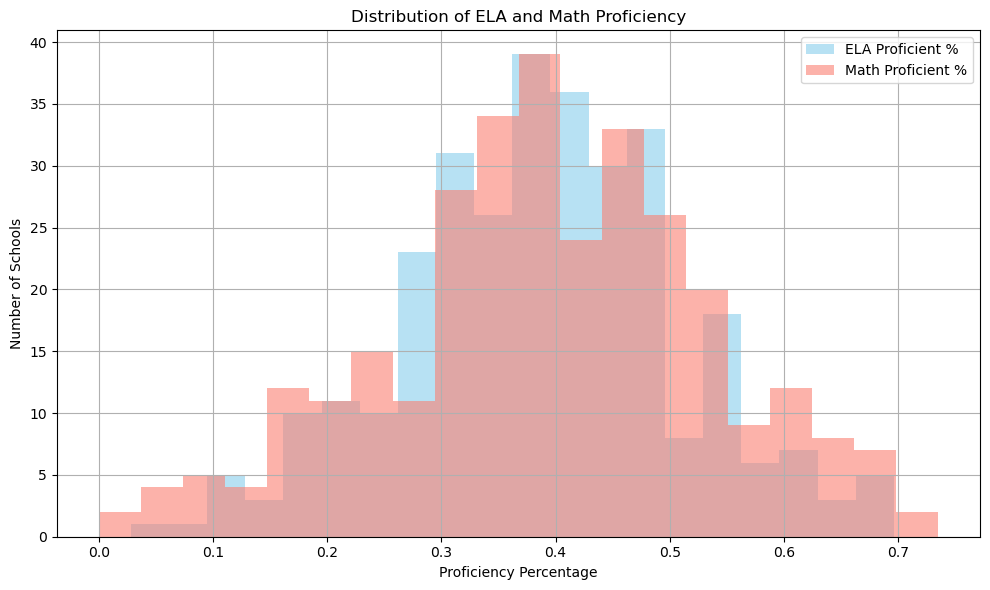

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(df["ELA Proficient %"], bins=20, alpha=0.6, label="ELA Proficient %", color="skyblue")
plt.hist(df["Math Proficient %"], bins=20, alpha=0.6, label="Math Proficient %", color="salmon")

plt.xlabel("Proficiency Percentage")
plt.ylabel("Number of Schools")
plt.title("Distribution of ELA and Math Proficiency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\lehma\AppData\Local\Temp\ipykernel_8424\184424167.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ethnicity, x="Ethnicity", y="Percentage", palette="Set2")


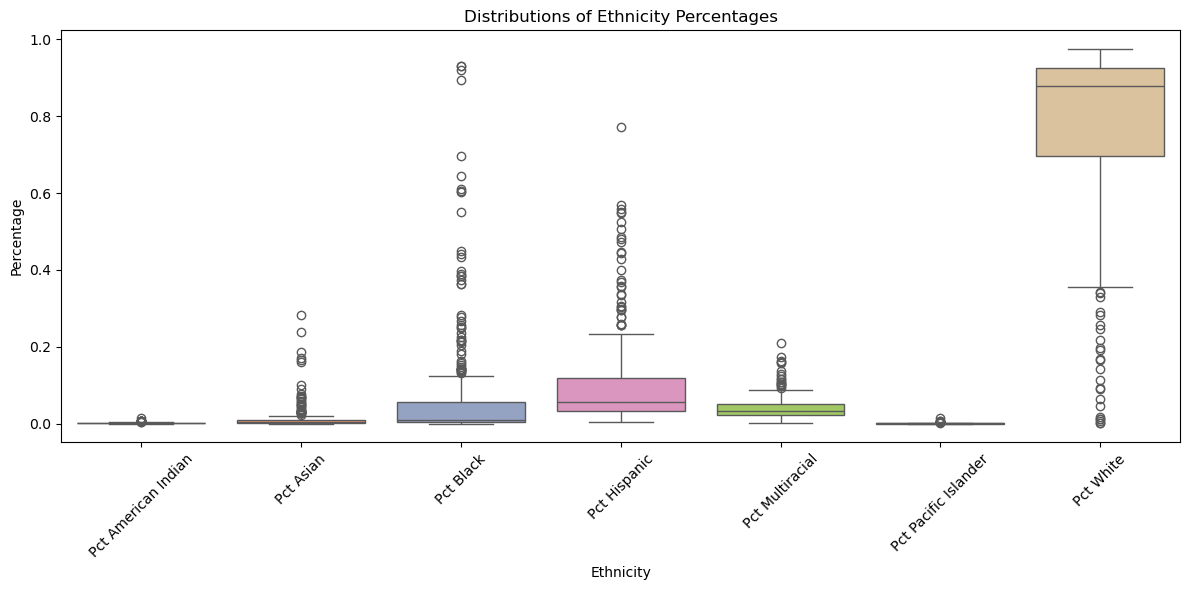

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

ethnicity_columns = [
    "Pct American Indian",
    "Pct Asian",
    "Pct Black",
    "Pct Hispanic",
    "Pct Multiracial",
    "Pct Pacific Islander",
    "Pct White"
]

df_ethnicity = df[ethnicity_columns].melt(var_name="Ethnicity", value_name="Percentage")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_ethnicity, x="Ethnicity", y="Percentage", palette="Set2")

plt.title("Distributions of Ethnicity Percentages")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

   Non-GCE Promote %     ELL %  Special Education %    FRPM_%  \
0           0.017691  0.023529             0.152941  0.271324   
1           0.042012  0.007600             0.179861  0.454718   
2           0.004467  0.100153             0.188838  0.455657   
3           0.024144  0.020649             0.119391  0.236400   
4           0.012208  0.036025             0.157700  0.237743   

   Chronically Absent Percent  AVG_ATT_RATE  Total Enrollment  \
0                    0.038941      0.966399              1360   
1                    0.092294      0.973404              1579   
2                    0.074315      0.957031              1308   
3                    0.031000      0.994553              7555   
4                    0.044749      0.961639              8383   

   Corp Per/Student  % Tested ELA  % Tested Math  Pct American Indian  \
0           9659.39      0.437500       0.437500             0.000735   
1          12311.39      0.346422       0.345155             0.002533   

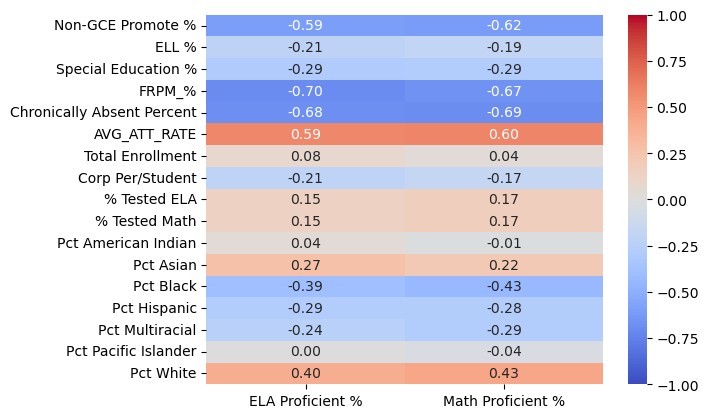

In [5]:
X = ["Non-GCE Promote %", 
     "ELL %", 
     "Special Education %", 
     "FRPM_%",  
     "Chronically Absent Percent", 
     "AVG_ATT_RATE", 
     "Total Enrollment", 
     "Corp Per/Student", 
     "% Tested ELA", 
     "% Tested Math",
     "Pct American Indian",
     "Pct Asian",
     "Pct Black",
     "Pct Hispanic",
     "Pct Multiracial",
     "Pct Pacific Islander",
     "Pct White"]
Y = ["ELA Proficient %", "Math Proficient %"]
subset = df[X + Y]
print(subset.head())
corrs = subset.corr().loc[X, Y]
feature_label_corr_map = plt.figure()
sns.heatmap(corrs, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.show()

In [6]:
feature_label_corr_map.savefig("feature_label_correlation_heatmap.png", dpi=300, bbox_inches='tight')

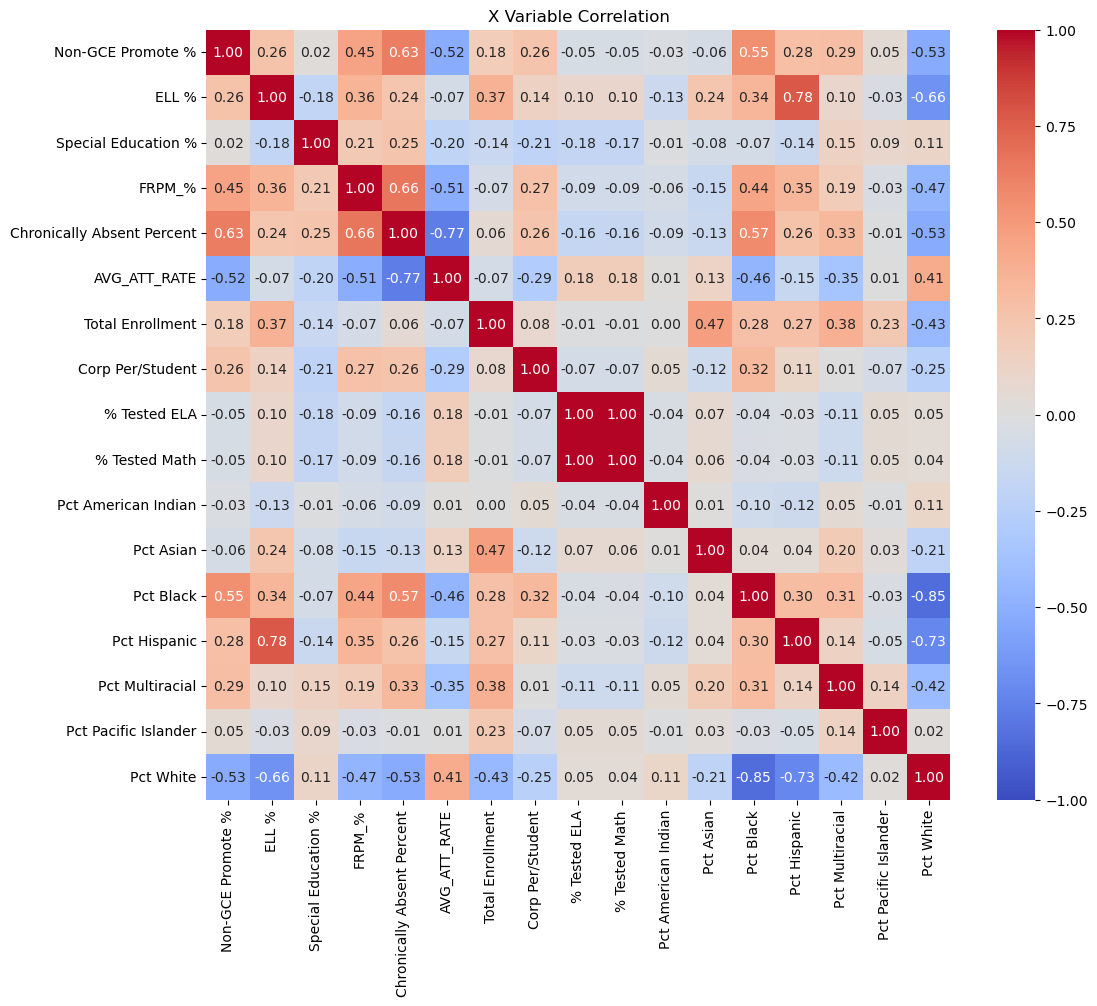

In [8]:
x_corr = df[X].corr()
feature_feature_corr_map = plt.figure(figsize=(12, 10))
sns.heatmap(x_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("X Variable Correlation")
plt.show()

In [9]:
feature_feature_corr_map.savefig("feature_feature_correlation_heatmap.png", dpi=300, bbox_inches='tight')

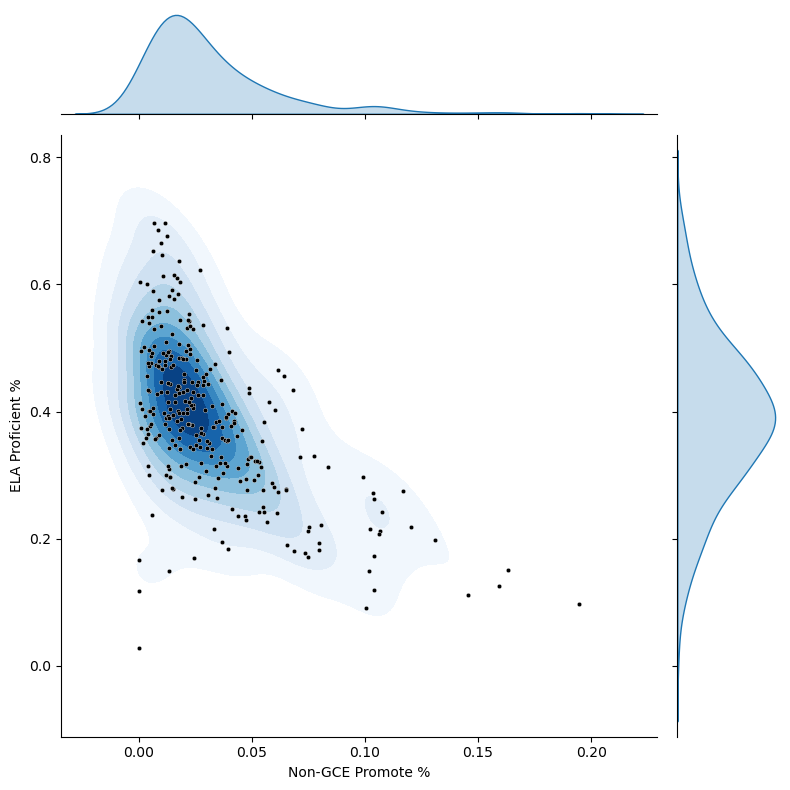

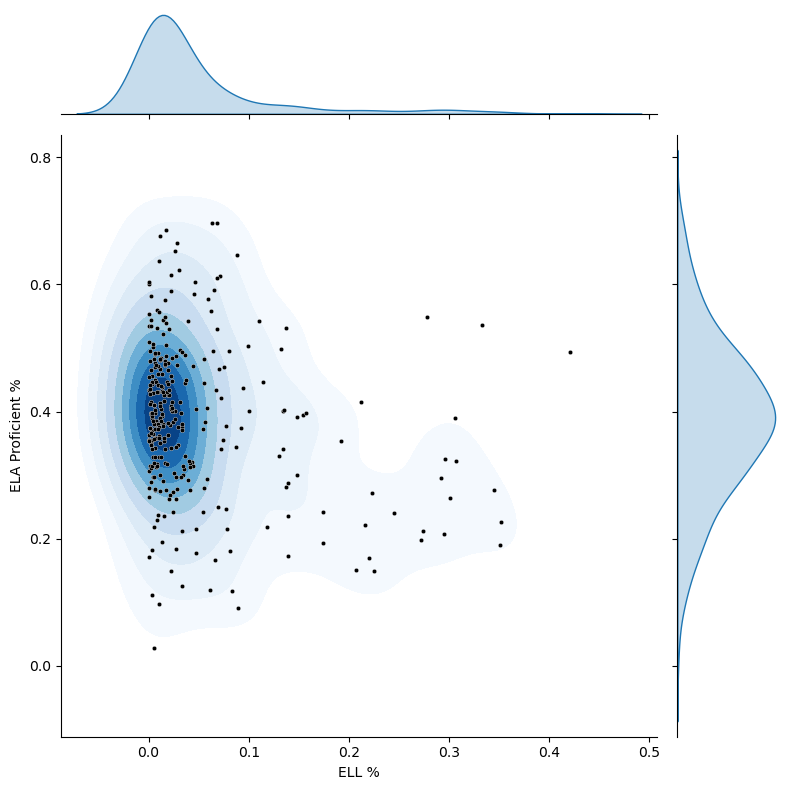

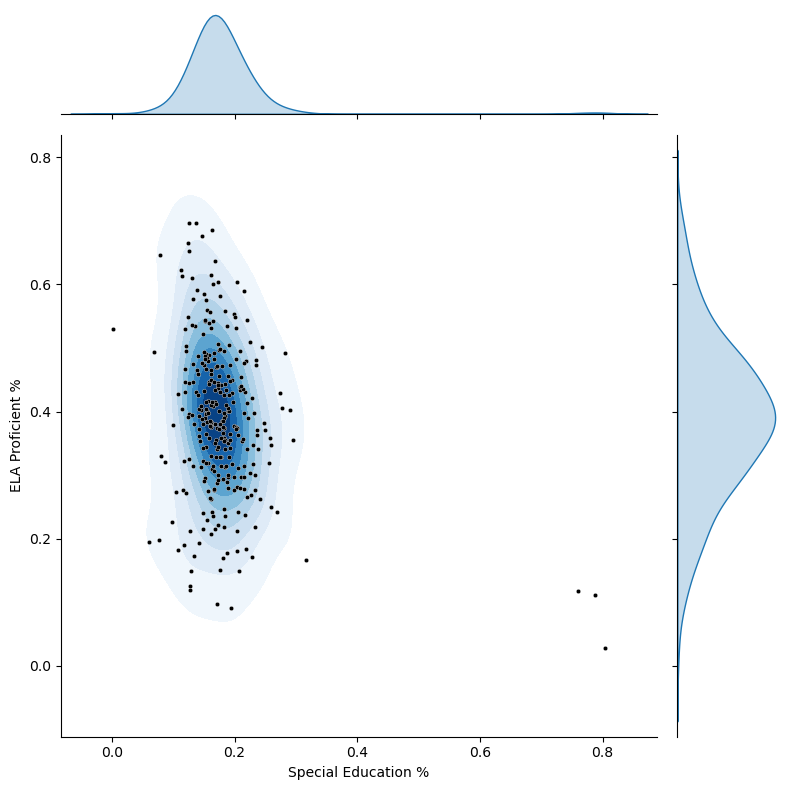

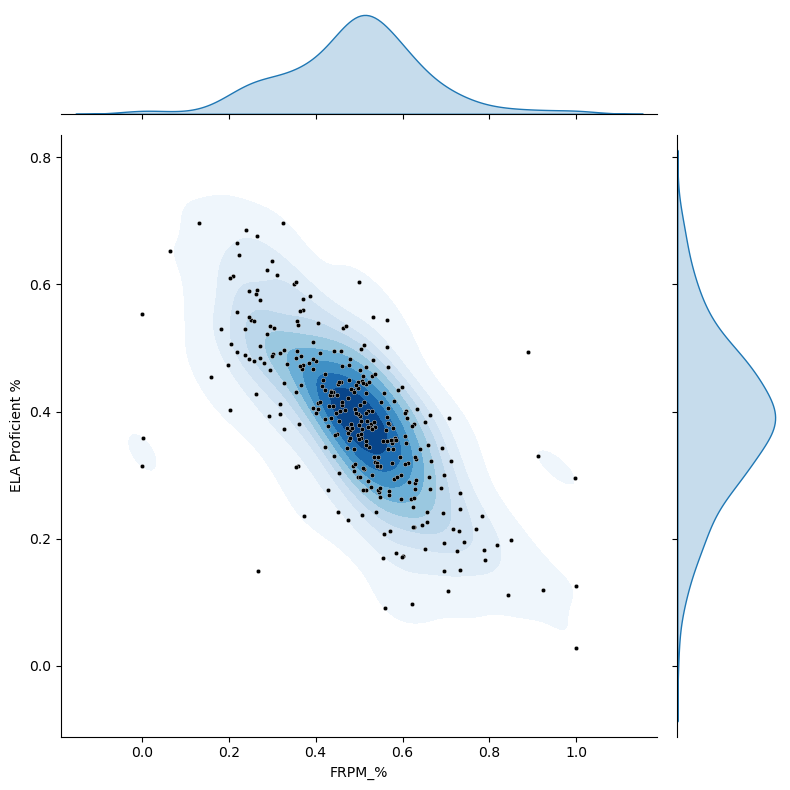

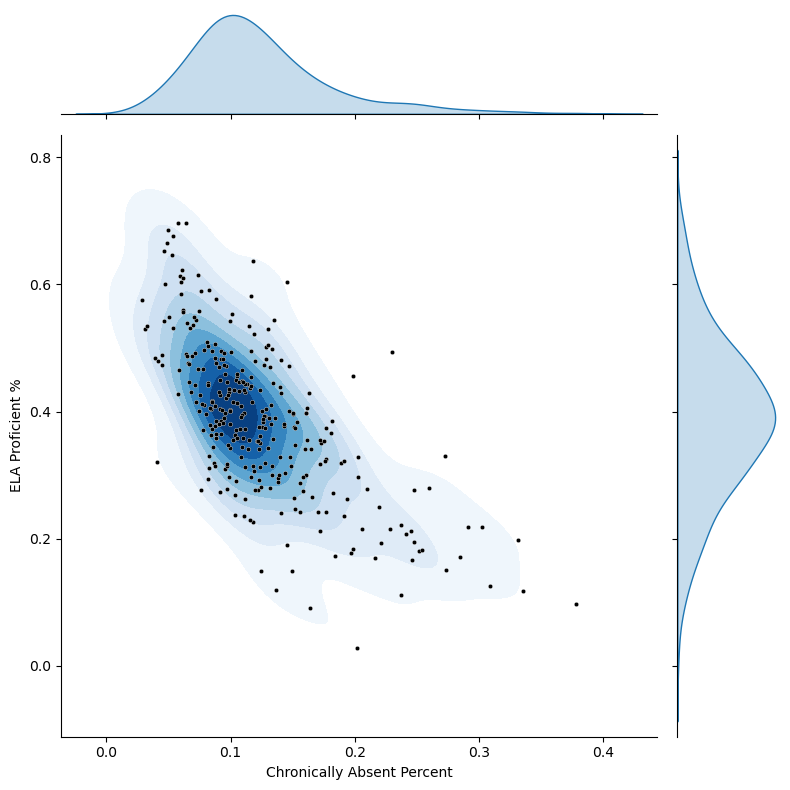

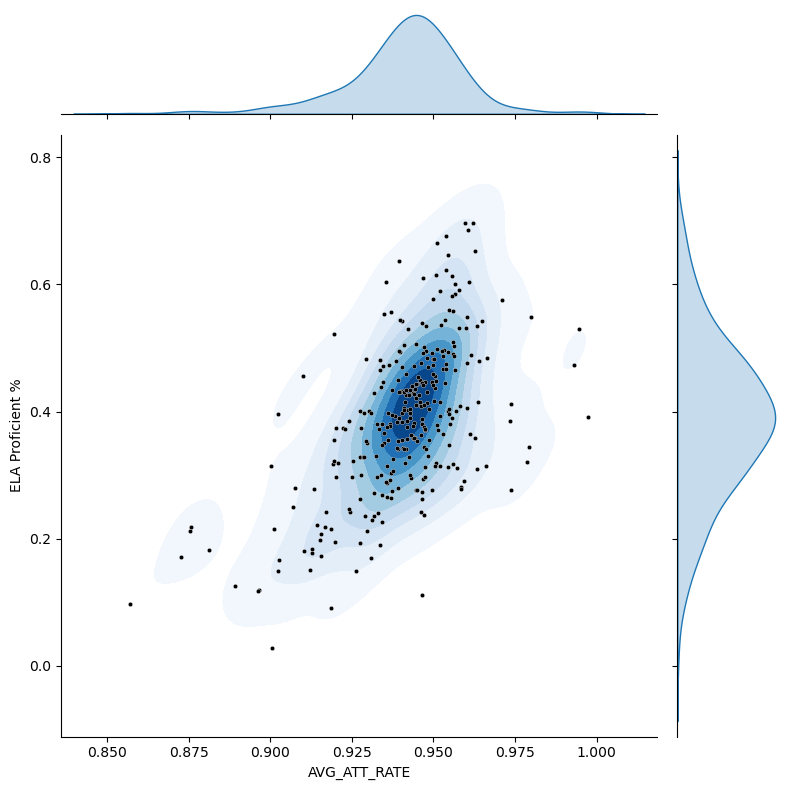

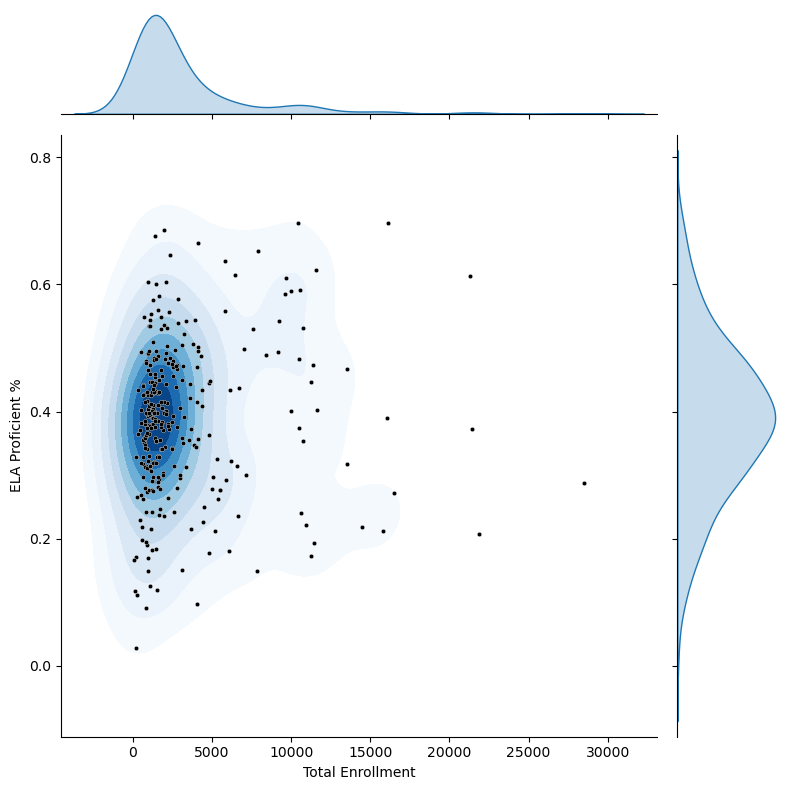

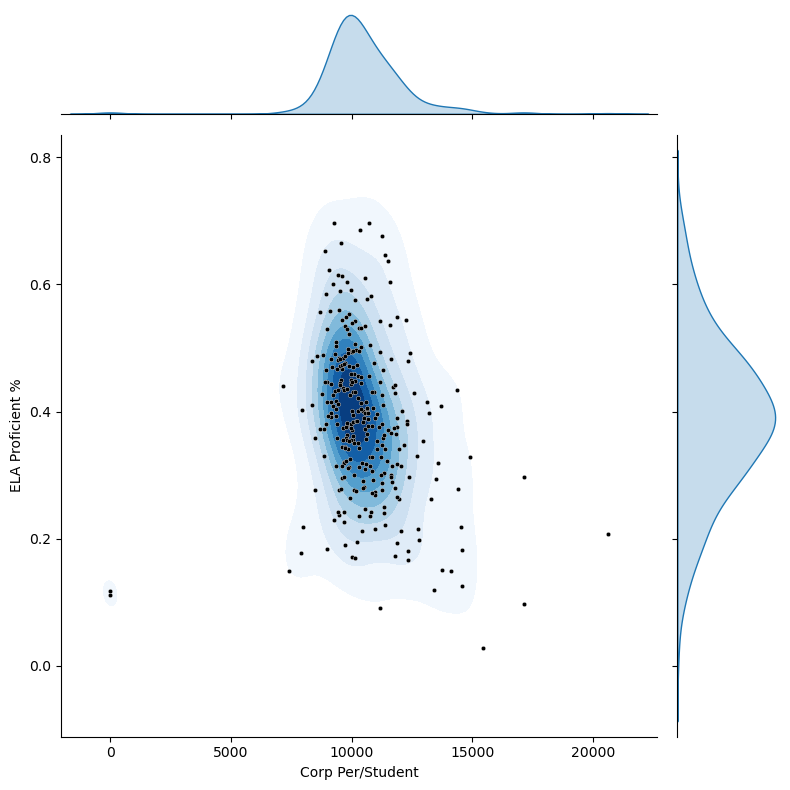

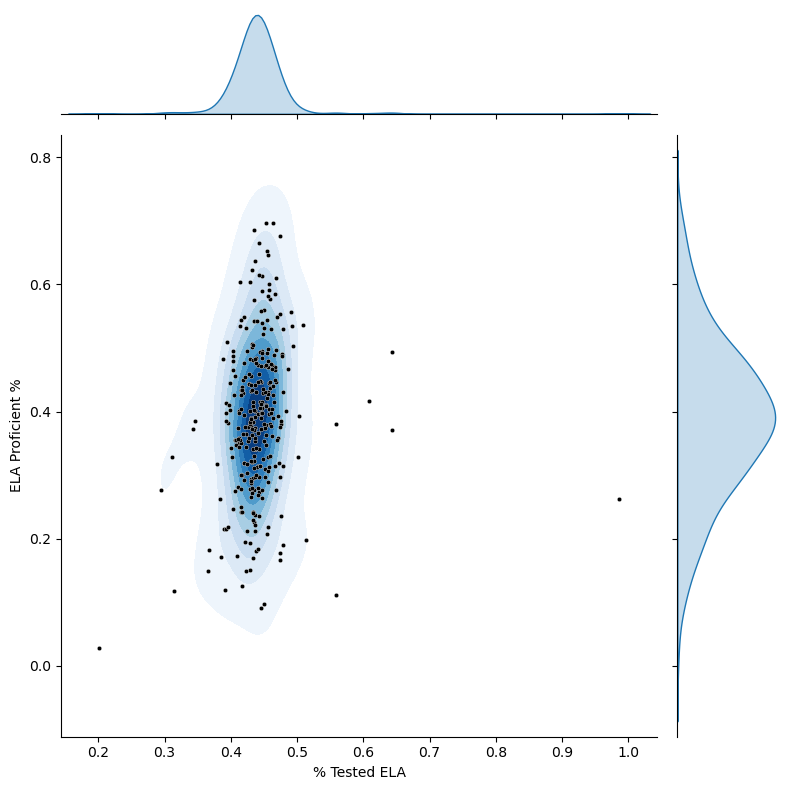

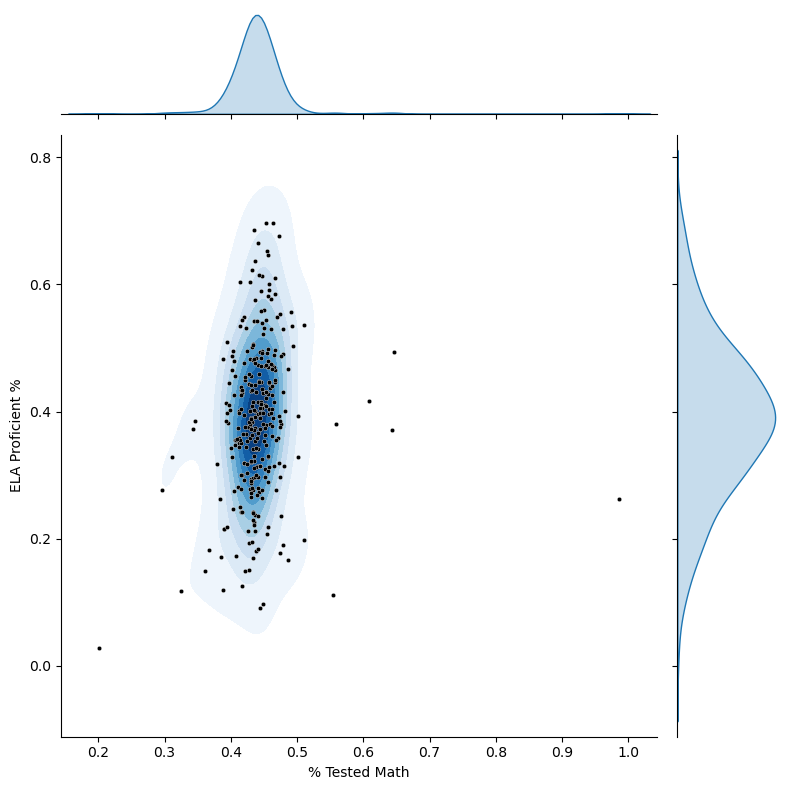

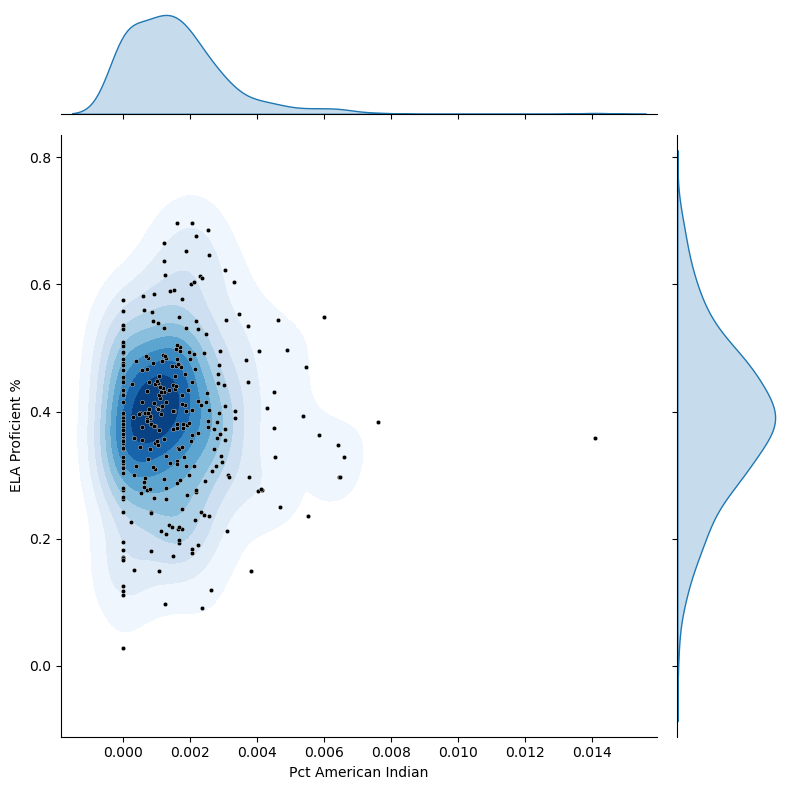

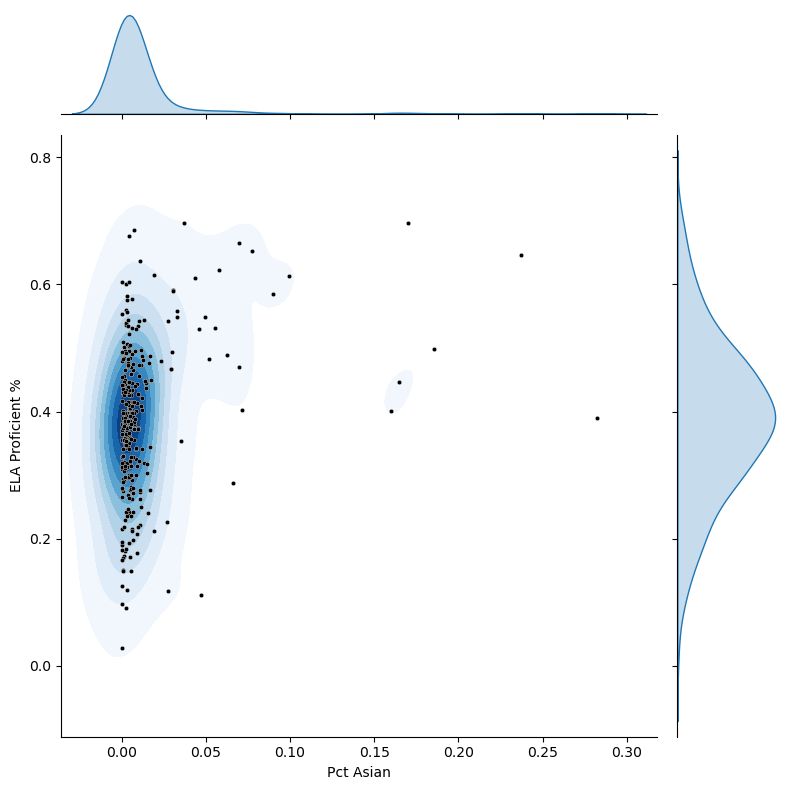

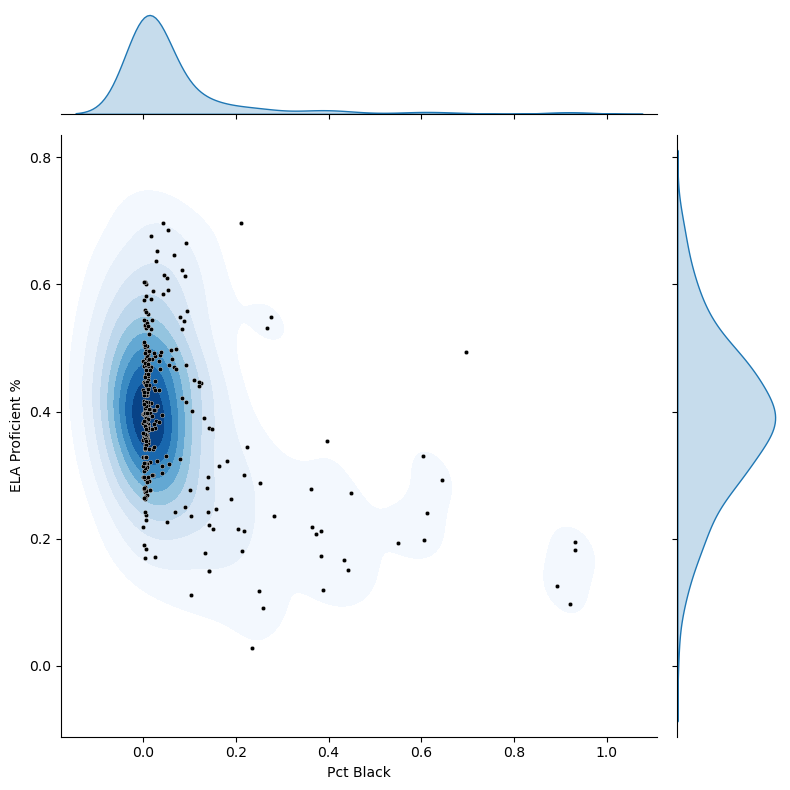

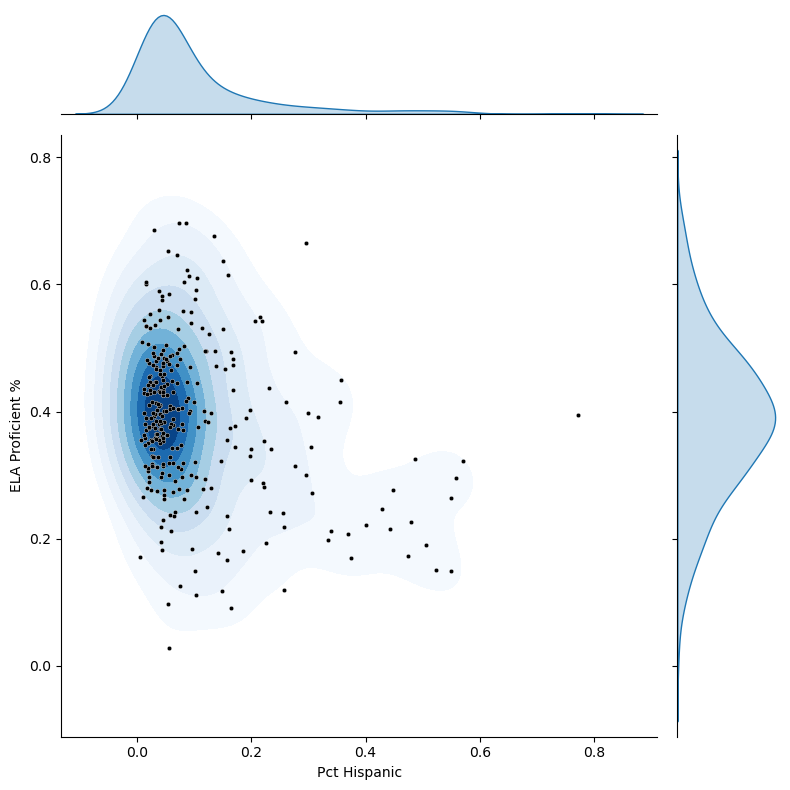

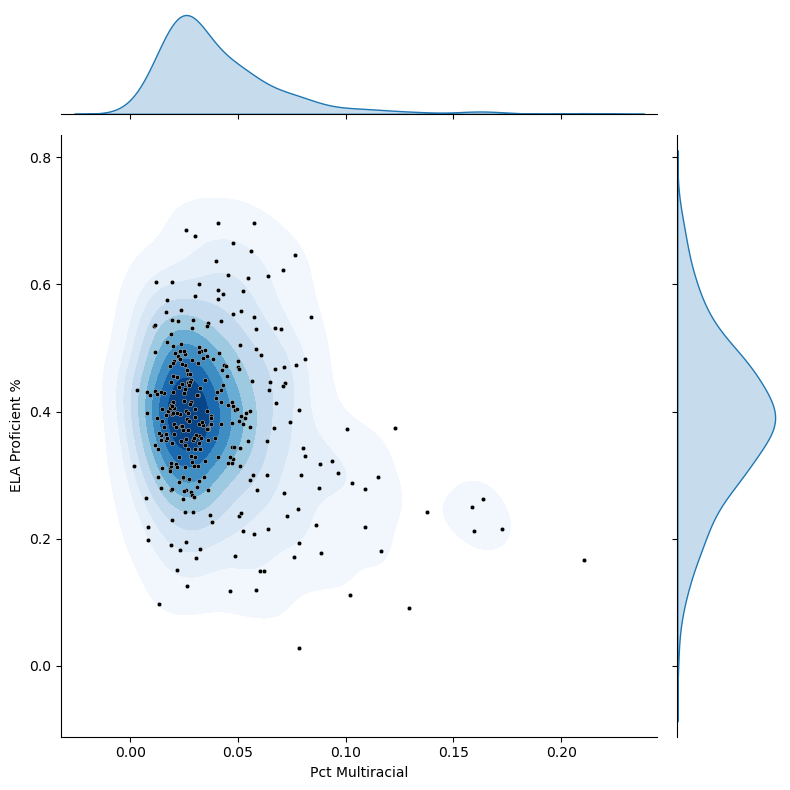

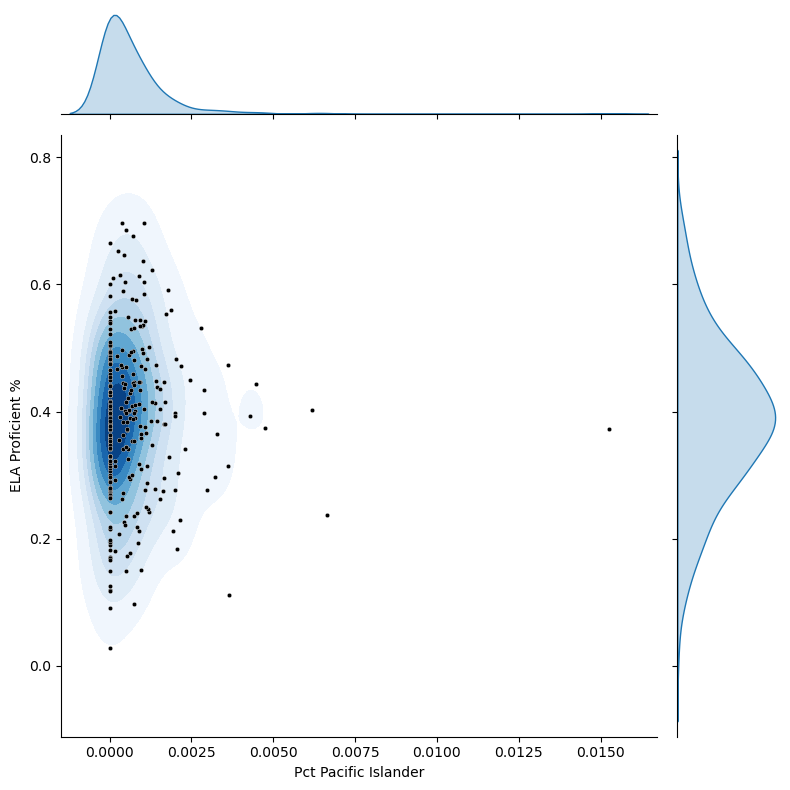

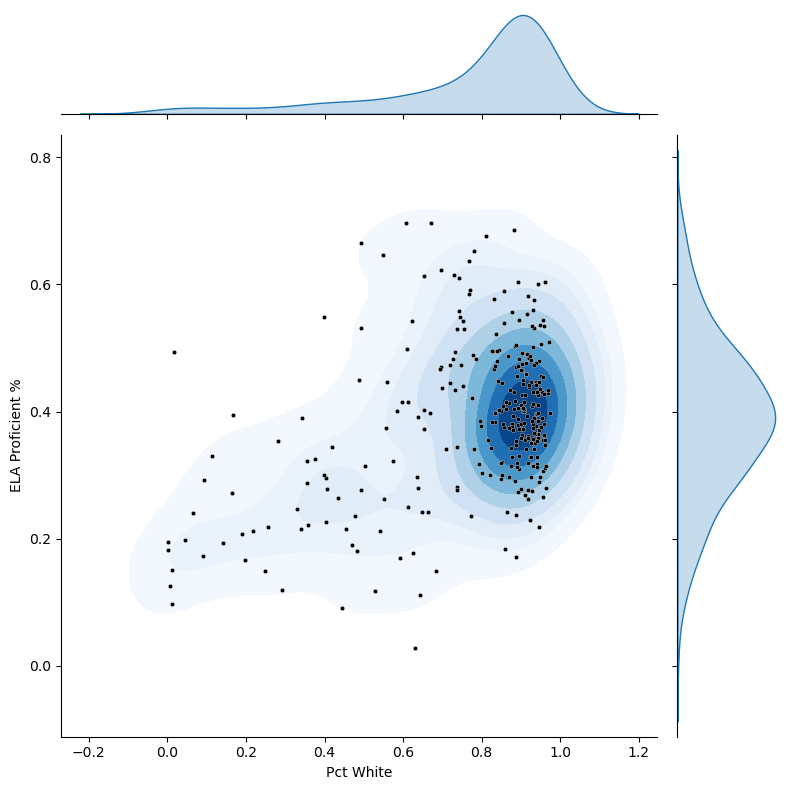

In [13]:
import re

for col in X:
    g = sns.jointplot(
        data=df,
        x=col,
        y="ELA Proficient %",
        kind="kde", 
        fill=True,  
        cmap="Blues", 
        height=8
    ).plot_joint(sns.scatterplot, s=10, color='black')

    safe_col_name = re.sub(r'[^\w]', '_', col)
    filename = f"scatter_{safe_col_name}.png"

    plt.show()

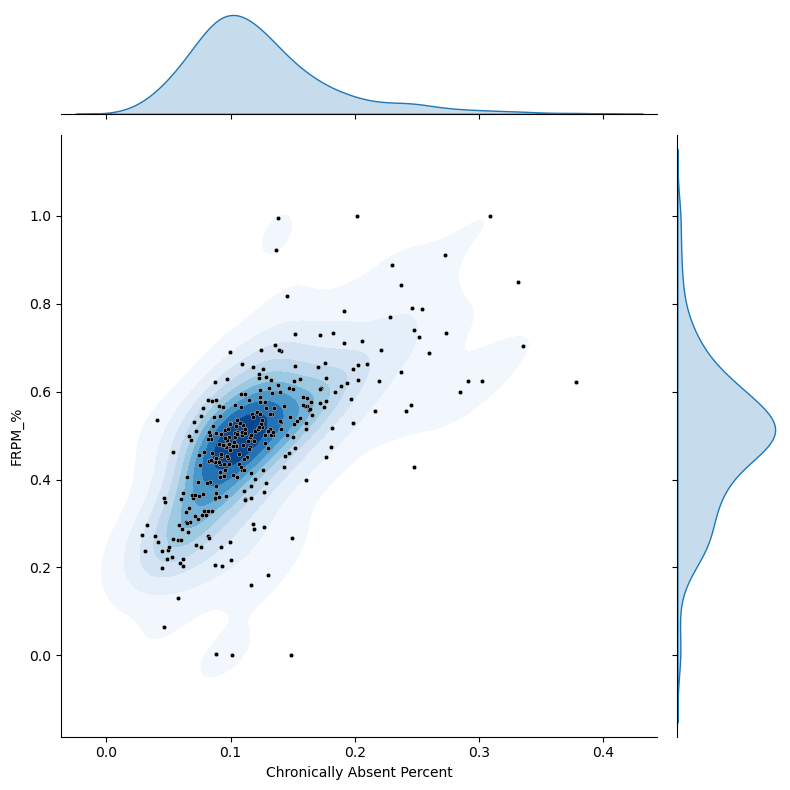

In [13]:
sns.jointplot(
    data=df,
    x="Chronically Absent Percent",
    y="FRPM_%",
    kind="kde", 
    fill=True,  
    cmap="Blues", 
    height=8
).plot_joint(sns.scatterplot, s=10, color='black') 

plt.show()

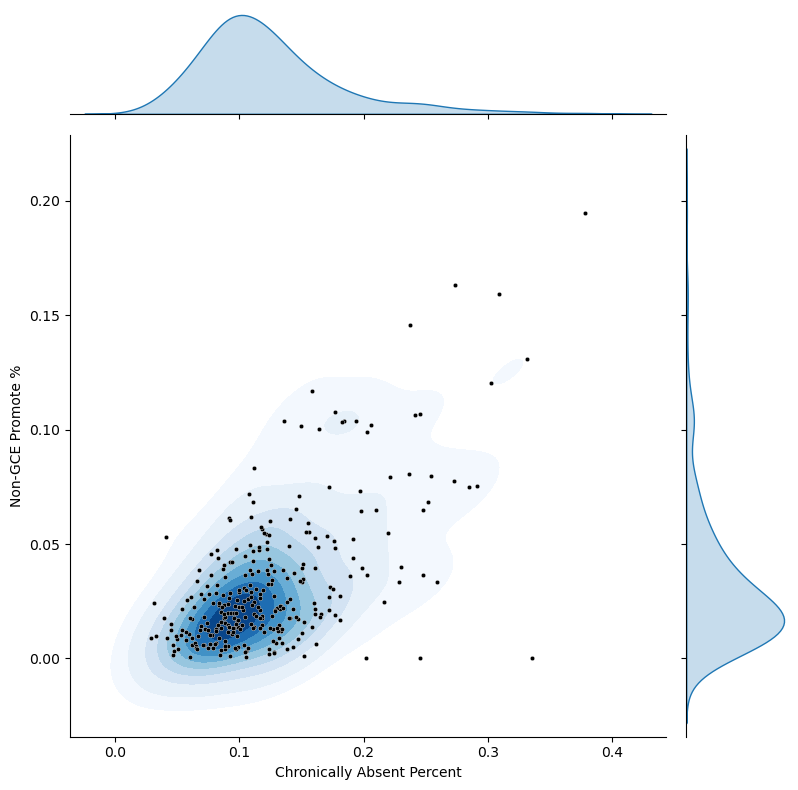

In [15]:
sns.jointplot(
    data=df,
    x="Chronically Absent Percent",
    y="Non-GCE Promote %",
    kind="kde", 
    fill=True,  
    cmap="Blues", 
    height=8
).plot_joint(sns.scatterplot, s=10, color='black') 

plt.show()